# Movies feelings analysis

## Importando bibliotecas

In [3]:
# === 1) Imports & setup ===
import os, re, random
import pandas as pd, numpy as np, matplotlib.pyplot as plt, seaborn as sns
import nltk; nltk.download('stopwords')
from nltk.corpus import stopwords
sns.set_theme()  # estilo visual do seaborn

RANDOM_STATE = 42
random.seed(RANDOM_STATE)
np.random.seed(RANDOM_STATE)

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


In [4]:
# Pastas para salvar saídas
os.makedirs('reports', exist_ok=True)

In [12]:

# Carregar dados
df = pd.read_csv('/content/imdb_dataset.csv')
df = df.rename(columns={'review': 'text', 'sentiment': 'label'})


In [13]:
# === 3) Sanidade básica ===
print("Formato:", df.shape)
print(df.head(3))
print("Nulos por coluna:\n", df.isna().sum())


Formato: (50000, 2)
                                                text     label
0  One of the other reviewers has mentioned that ...  positive
1  A wonderful little production. <br /><br />The...  positive
2  I thought this was a wonderful way to spend ti...  positive
Nulos por coluna:
 text     0
label    0
dtype: int64


In [14]:
# Procuramos por duplicatas exatas (texto, label) e imprimimos alguns exemplos

before = len(df)
dups_exact = df.duplicated(subset=['text','label'], keep=False)
print("Duplicatas exatas (text+label):", dups_exact.sum())

# Amostra de 5 pares (mesmo text+label)
ex_dups = (df.loc[dups_exact, ['text','label']]
             .groupby(['text','label'])
             .head(2)  # mostra duas ocorrências
             .head(10))  # limita linhas exibidas

# Trunca os textos para visualizar melhor
ex_dups_display = ex_dups.copy()
ex_dups_display['text'] = ex_dups_display['text'].str.slice(0, 220)
ex_dups_display

Duplicatas exatas (text+label): 824


,text,label
42,"Of all the films I have seen, this one, The Ra...",negative
84,"We brought this film as a joke for a friend, a...",negative
140,"Before I begin, let me get something off my ch...",negative
219,Ed Wood rides again. The fact that this movie ...,negative
245,I have seen this film at least 100 times and I...,positive
480,From director Barbet Schroder (Reversal of For...,negative
513,"The story and the show were good, but it was r...",negative
636,I rented this thinking it would be pretty good...,negative
638,This movie has everything typical horror movie...,positive
701,I Enjoyed Watching This Well Acted Movie Very ...,positive


In [15]:
"""
Removemos duplicatas exatas por (text, label) para evitar contagem dupla de exemplos idênticos.
Em seguida, auditamos textos repetidos com rótulos conflitantes, apenas reportando sua frequência para decisão futura.
O processo foi realizado antes da divisão treino/validação para mitigar vazamento de dados.
"""
before = len(df)

# 1) Remover duplicatas exatas (texto + rótulo)
df = df.drop_duplicates(subset=['text', 'label']).reset_index(drop=True)

# 2) Auditar conflitos de rótulo para o mesmo texto
conflict_mask = df.duplicated(subset=['text'], keep=False)
conflicts = (df.loc[conflict_mask]
               .groupby('text')['label']
               .nunique()
               .reset_index(name='n_labels'))
n_conflicts = (conflicts['n_labels'] > 1).sum()

after = len(df)
print(f"Removidas {before - after} duplicatas exatas (texto+label).")
print(f"Textos com rótulos conflitantes: {n_conflicts}")

Removidas 418 duplicatas exatas (texto+label).
Textos com rótulos conflitantes: 0


Identificamos 824 linhas pertencentes a 406 grupos de duplicatas exatas por (text,label). Mantivemos uma ocorrência por grupo e removemos 418 linhas duplicadas, antes do split de treino/validação (alguns grupos tinham mais de duas ocorrências).

In [28]:
# Schema simples (contrato de dados)
assert df['text'].map(lambda x: isinstance(x, str)).all(), "Há linhas sem texto (não-string)."
assert set(df['label'].unique()) <= {'positive','negative'}, "Labels fora do conjunto esperado."

# Confirmação (só é executado se as verificações acima forem verdadeiras)
print(
    "OK: schema verificado — coluna 'text' é string e 'label' contém apenas {'positive','negative'}.\n"
    f"Registros: {len(df)} | Distribuição de classes: {df['label'].value_counts().to_dict()}"
)

# Salvar dataset limpo
CSV_OUT = '/content/data-processed/imdb_clean.csv'
os.makedirs('/content/data-processed', exist_ok=True)

df_clean = df[['text','label']].copy()
df_clean.to_csv(CSV_OUT, index=False)

# feedback útil
counts = df_clean['label'].value_counts().to_dict()
print(f"Salvo: {CSV_OUT} | Registros: {len(df_clean)} | Distribuição: {counts}")

OK: schema verificado — coluna 'text' é string e 'label' contém apenas {'positive','negative'}.
Registros: 49582 | Distribuição de classes: {'positive': 24884, 'negative': 24698}
Salvo: /content/data-processed/imdb_clean.csv | Registros: 49582 | Distribuição: {'positive': 24884, 'negative': 24698}


      label  count    pct
0  positive  24884  50.19
1  negative  24698  49.81


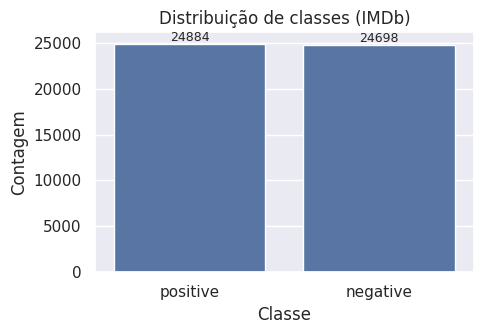

In [18]:
# === 4) Distribuição de classes ===
counts = (df['label']
          .value_counts()
          .rename_axis('label')
          .reset_index(name='count'))
counts['pct'] = (counts['count'] / counts['count'].sum() * 100).round(2)
print(counts)

plt.figure(figsize=(5,3.5))
ax = sns.barplot(data=counts, x='label', y='count')
ax.set_title('Distribuição de classes (IMDb)')
ax.set_xlabel('Classe'); ax.set_ylabel('Contagem')
for p in ax.patches:
    ax.annotate(f"{p.get_height():.0f}",
                (p.get_x()+p.get_width()/2, p.get_height()),
                ha='center', va='bottom', fontsize=9)
plt.tight_layout(); plt.savefig('reports/class_balance.png', dpi=150)
plt.show()

count    49582.000000
mean       231.350167
std        171.542020
min          4.000000
25%        126.000000
50%        173.000000
75%        281.000000
max       2470.000000
Name: text_len, dtype: float64


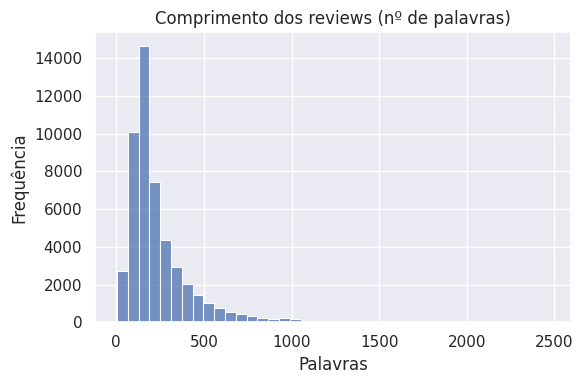

In [19]:
# === 5) Comprimento dos textos ===
df['text_len'] = df['text'].str.split().str.len()
print(df['text_len'].describe())

plt.figure(figsize=(6,4))
sns.histplot(df['text_len'], bins=40)
plt.title('Comprimento dos reviews (nº de palavras)')
plt.xlabel('Palavras'); plt.ylabel('Frequência')
plt.tight_layout(); plt.savefig('reports/text_len_hist.png', dpi=150)
plt.show()


In [25]:
# === 6) Exemplos de linhas (1 pos, 1 neg, 1 mediano por comprimento) ===
ex_pos = df[df['label']=='positive'].sample(1, random_state=RANDOM_STATE)['text'].iloc[0]
ex_neg = df[df['label']=='negative'].sample(1, random_state=RANDOM_STATE)['text'].iloc[0]
mid_idx = (df['text_len'] - df['text_len'].median()).abs().sort_values().index[0]
ex_mid = df.loc[mid_idx, 'text']

print("\nEXEMPLO POSITIVO:\n", ex_pos[:140], "\n")
print("EXEMPLO NEGATIVO:\n", ex_neg[:140], "\n")


EXEMPLO POSITIVO:
 Not since The Simpsons made it's debut has there been a sitcom that I didn't want to turn of in a matter of 2 minutes. It has of course been 

EXEMPLO NEGATIVO:
 I usually much prefer French movies over American ones, with explosions and car chases, but this movie was very disappointing. There is no w 



In [26]:
# === 7) Top termos por classe (limpeza simples) ===
stop_en = set(stopwords.words('english'))

def basic_clean(s: str):
    s = s.lower()
    s = re.sub(r'http\S+|www\.\S+', ' ', s)     # URLs
    s = re.sub(r'[^a-z\s]', ' ', s)             # mantém só letras e espaço
    toks = [w for w in s.split() if w not in stop_en and len(w) > 2]
    return toks

from collections import Counter

def top_words(subdf, k=15, cap=20000):
    c = Counter()
    # limitar a cap linhas p/ rapidez (ajuste se quiser)
    for t in subdf['text'].head(cap):
        c.update(basic_clean(t))
    top = pd.DataFrame(c.most_common(k), columns=['term','count'])
    return top

top_pos = top_words(df[df['label']=='positive'], k=15)
top_neg = top_words(df[df['label']=='negative'], k=15)

top_pos.to_csv('reports/top_terms_positive.csv', index=False)
top_neg.to_csv('reports/top_terms_negative.csv', index=False)
print("\nTop termos (positive):\n", top_pos.head())
print("\nTop termos (negative):\n", top_neg.head())


Top termos (positive):
     term  count
0   film  33575
1  movie  30459
2    one  21849
3   like  14104
4   good  12107

Top termos (negative):
     term  count
0  movie  40147
1   film  30079
2    one  20937
3   like  17936
4   even  12278


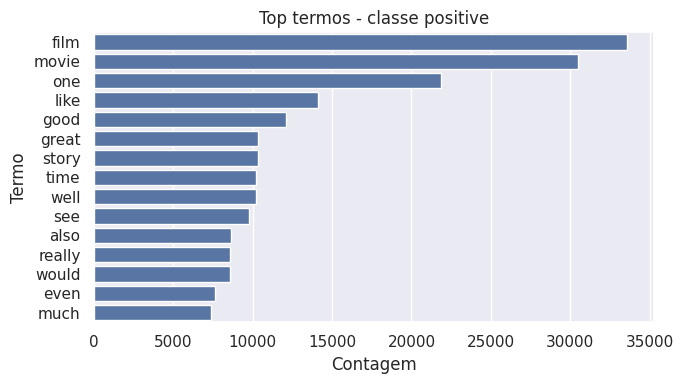

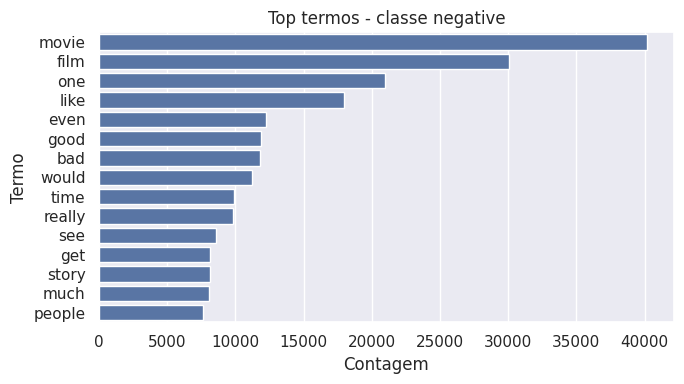

In [27]:
# Plots dos top termos
plt.figure(figsize=(7,4))
sns.barplot(data=top_pos, x='count', y='term')
plt.title('Top termos - classe positive')
plt.xlabel('Contagem'); plt.ylabel('Termo')
plt.tight_layout(); plt.savefig('reports/top_terms_positive.png', dpi=150)
plt.show()

plt.figure(figsize=(7,4))
sns.barplot(data=top_neg, x='count', y='term')
plt.title('Top termos - classe negative')
plt.xlabel('Contagem'); plt.ylabel('Termo')
plt.tight_layout(); plt.savefig('reports/top_terms_negative.png', dpi=150)
plt.show()